In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

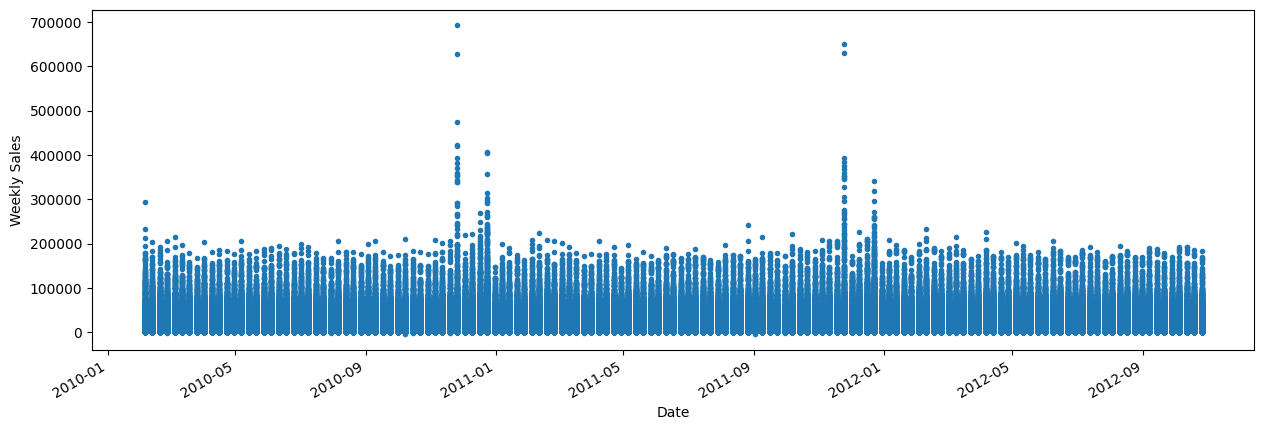

In [35]:
df = pd.read_csv('Data/train.csv')
df['IsHoliday'] = df['IsHoliday'].astype(int)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df['Weekly_Sales'].plot(style='.', figsize=(15,5), xlabel='Date', ylabel='Weekly Sales')
plt.show()


In [36]:
def add_lags(df, lags=[1, 2, 52]):
    for lag in lags:
        df[f'lag_{lag}'] = df['Weekly_Sales'].shift(lag)
    return df

def add_rolling_averages(df, windows=[4, 12, 26, 52]):
    for w in windows:
        df[f'rolling_{w}'] = df['Weekly_Sales'].shift(1).rolling(window=w).mean()
    return df

def create_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    return df

In [37]:
df = create_features(df)
df = add_lags(df, lags=[1, 2, 52])
df = add_rolling_averages(df) 

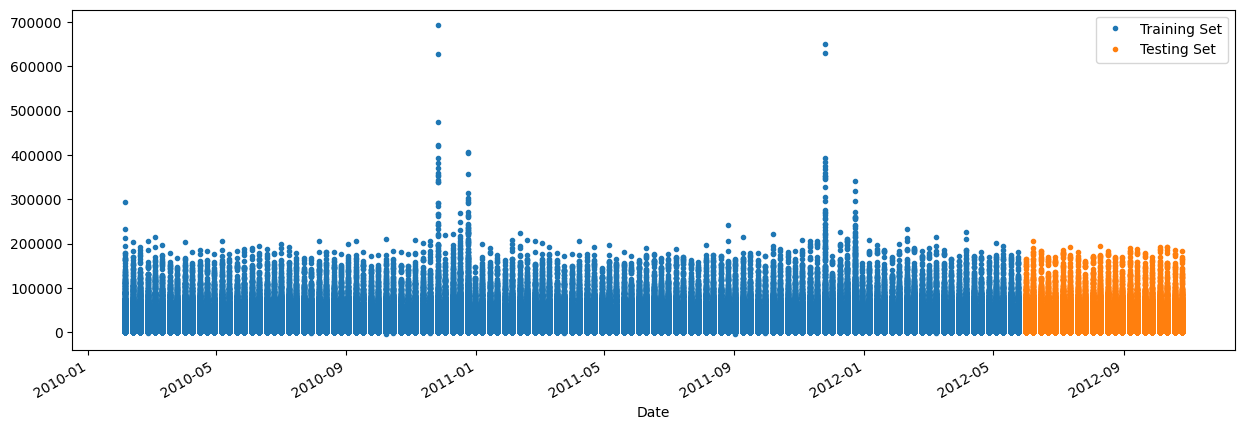

In [38]:
df = df.sort_index()
train = df.loc[df.index < '2012-05-31'].copy()
test = df.loc[df.index >= '2012-05-31'].copy()
train = train.dropna()

fig, ax = plt.subplots(figsize=(15,5))
train['Weekly_Sales'].plot(style='.', ax=ax, label='Training Set')
test['Weekly_Sales'].plot(style='.', ax=ax, label='Testing Set')
plt.legend()
plt.show()



In [39]:
features = ['Store', 'Dept', 'IsHoliday', 'dayofweek', 'year','month', 'quarter', 'dayofyear',
            'lag_1', 'lag_2', 'lag_52', 'rolling_4', 'rolling_12', 'rolling_26', 'rolling_52']

X_train = train[features]
y_train = train['Weekly_Sales']
X_test = test[features]
y_test = test['Weekly_Sales']

In [40]:
model = XGBRegressor()
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [41]:
y_pred = model.predict(X_test)


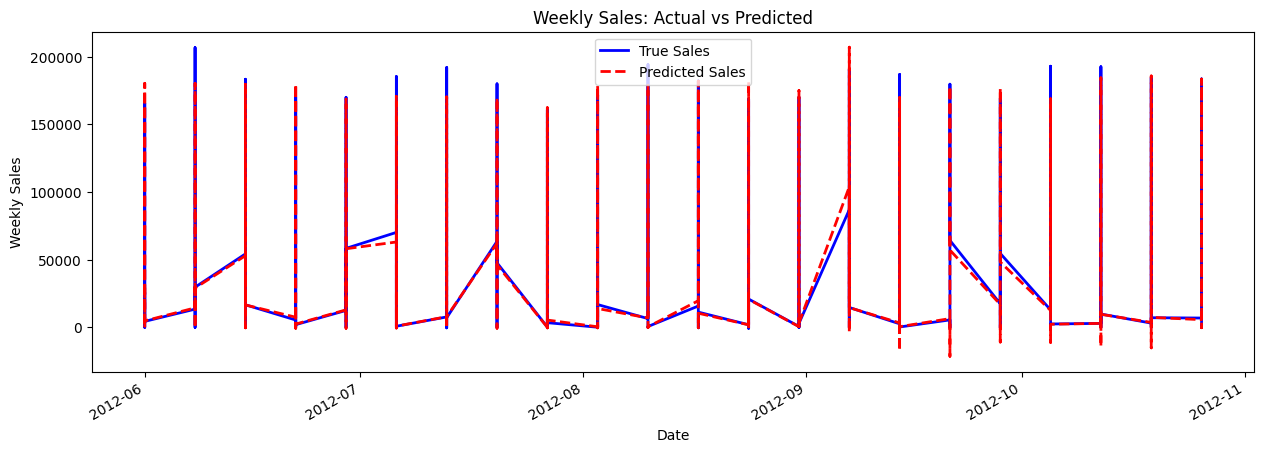

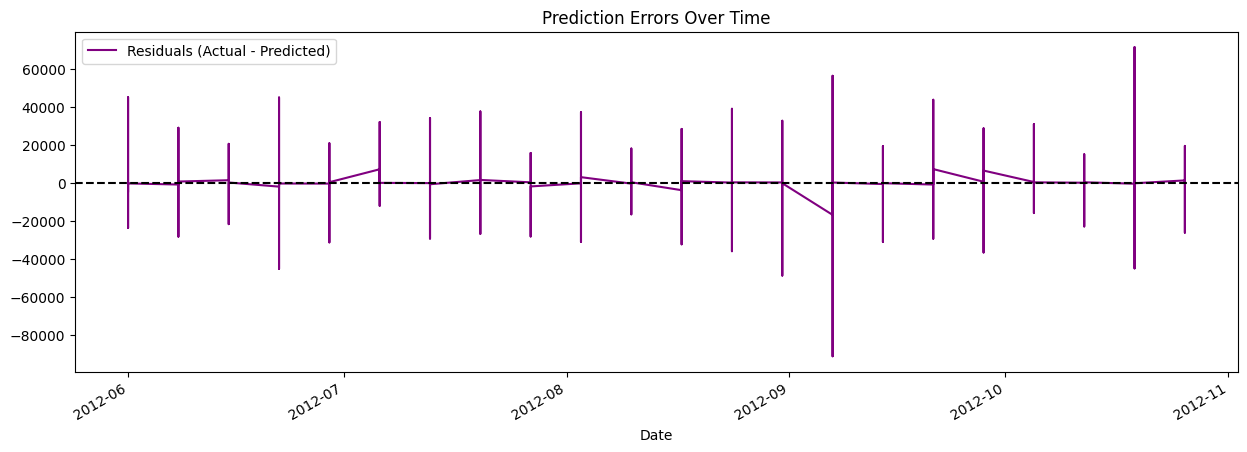

In [42]:
test = test.copy()
test['prediction'] = y_pred


fig, ax = plt.subplots(figsize=(15,5))

y_test.plot(ax=ax, label='True Sales', color='blue', linewidth=2)
test['prediction'].plot(ax=ax, label='Predicted Sales', color='red', linestyle='--', linewidth=2)

plt.legend()
ax.set_title('Weekly Sales: Actual vs Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
plt.show()


residuals = y_test - test['prediction']

fig, ax = plt.subplots(figsize=(15,5))
residuals.plot(ax=ax, label='Residuals (Actual - Predicted)', color='purple')
ax.axhline(0, color='black', linestyle='--')
plt.legend()
plt.title("Prediction Errors Over Time")
plt.show()


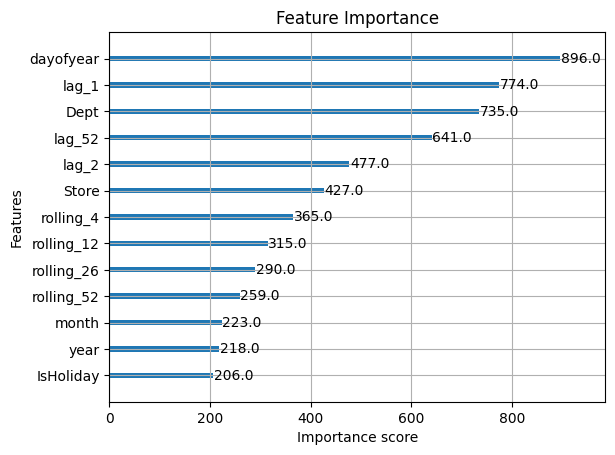

In [43]:
from xgboost import plot_importance

plot_importance(model, importance_type='weight')
plt.title('Feature Importance')
plt.show()